In [1]:
import blosc2
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

# create random data

X = np.random.normal(size=(1_000, 2))

n_prototypes = 4

In [3]:
from models import CMeans, AA, KMeans

C:\Users\aalcacer\Miniconda3\envs\ra-blosc-codecs\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
cmeans_model = CMeans(n_prototypes, m=2, max_iter=100, tol=1e-6)
_ = cmeans_model.fit(X)

In [8]:
cmeans_prototypes = cmeans_model.prototypes

In [9]:
aa_model = AA(n_prototypes, n_init=1, max_iter=100, tol=1e-6)
_ = aa_model.fit(X)

In [10]:
aa_prototypes = aa_model.prototypes

In [11]:
kmeans_model = KMeans(n_prototypes, n_init=1, max_iter=100, tol=1e-6)
_ = kmeans_model.fit(X)

C:\Users\aalcacer\Miniconda3\envs\ra-blosc-codecs\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\aalcacer\Miniconda3\envs\ra-blosc-codecs\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [12]:
kmeans_prototypes = kmeans_model.prototypes

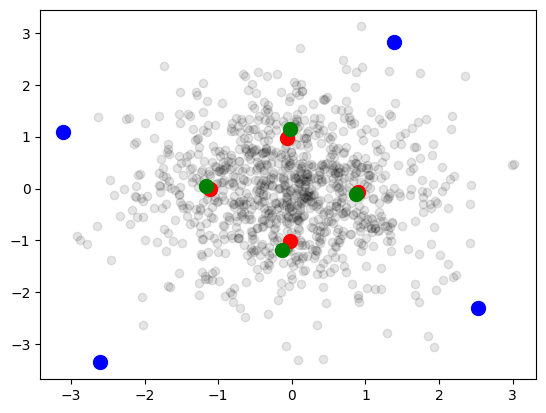

In [13]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c='black', alpha=0.1)
plt.scatter(cmeans_prototypes[:, 0], cmeans_prototypes[:, 1], c='red', s=100)
plt.scatter(aa_prototypes[:, 0], aa_prototypes[:, 1], c='blue', s=100)
plt.scatter(kmeans_prototypes[:, 0], kmeans_model.prototypes[:, 1], c='green', s=100)
plt.show()

## Real dataset

In [294]:
from sklearn.datasets import fetch_olivetti_faces, fetch_openml
faces = fetch_olivetti_faces(shuffle=True, random_state=0)
# mnist = fetch_openml('mnist_784', version=1, as_frame=False)
# minist_data = mnist.data
# minist_target = mnist.target


In [299]:
data = faces.images

n_samples = data.shape[0]

data.shape

(400, 64, 64)

In [469]:
# Preprocessing

from sklearn.feature_extraction import image

block_size = 4

patcher = image.PatchExtractor(patch_size=(block_size, block_size), max_patches=n_samples, random_state=0)
tiled_data = patcher.fit_transform(data)


In [470]:
# Select a subset of the data randomly
n_samples_subset = 1_000

idx = np.random.choice(tiled_data.shape[0], n_samples_subset, replace=False)

X = tiled_data[idx].reshape(n_samples_subset, -1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_pre = scaler.fit_transform(X)

# Pretrain the models

In [471]:
n_prototypes = 36

In [472]:
cmeans_model = CMeans(n_prototypes, m=2, max_iter=100, tol=1e-6, metric='cosine')
_ = cmeans_model.fit(X_pre)

In [473]:
kmeans_model = KMeans(n_prototypes, n_init=1, max_iter=100, tol=1e-6)
_ = kmeans_model.fit(X_pre)

In [474]:
aa_model = AA(n_prototypes, n_init=1, max_iter=100, tol=1e-6)
_ = aa_model.fit(X_pre)

In [475]:
# display prototypes
cmeans_prototypes = scaler.inverse_transform(cmeans_model.prototypes)
aa_prototypes = scaler.inverse_transform(aa_model.prototypes)
kmeans_prototypes = scaler.inverse_transform(kmeans_model.prototypes)

cmeans_weights = cmeans_model.transform(X_pre)
aa_weights = aa_model.transform(X_pre)
kmeans_weights = kmeans_model.transform(X_pre)

In [476]:
# Explained variance

from sklearn.metrics import explained_variance_score

cmeans_reconstruction = cmeans_weights @ cmeans_prototypes
aa_reconstruction = aa_weights @ aa_prototypes
kmeans_reconstruction = kmeans_weights @ kmeans_prototypes

cmeans_var_explained = explained_variance_score(X, cmeans_reconstruction)
aa_var_explained = explained_variance_score(X, aa_reconstruction)
kmeans_var_explained = explained_variance_score(X, kmeans_reconstruction)

# print in percentage
cmeans_var_explained *= 100
aa_var_explained *= 100
kmeans_var_explained *= 100

print(f'CMeans explained variance: {cmeans_var_explained:.2f}%')
print(f'AA explained variance: {aa_var_explained:.2f}%')
print(f'KMeans explained variance: {kmeans_var_explained:.2f}%')

CMeans explained variance: 81.31%
AA explained variance: 98.99%
KMeans explained variance: 91.25%


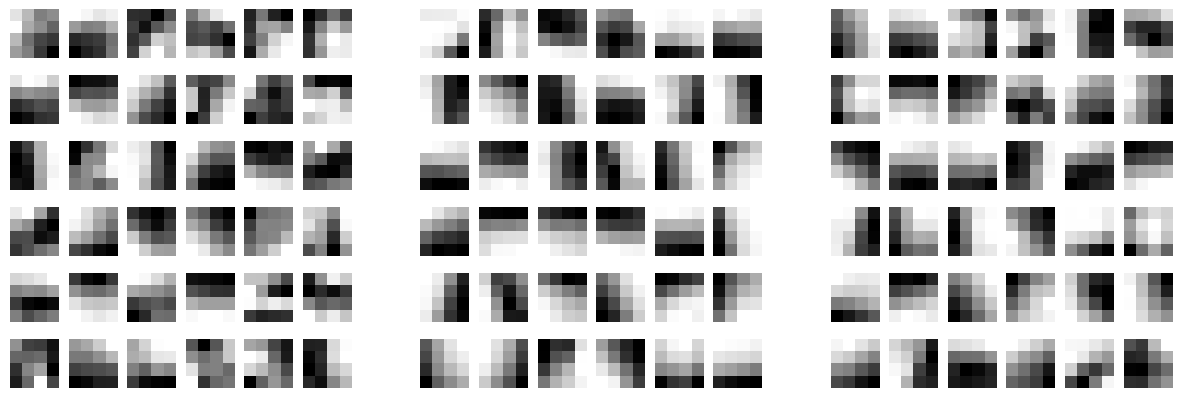

In [477]:
# Create a gridspec for AA and CMeans

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)

grid_size = (int(np.sqrt(n_prototypes)), int(np.sqrt(n_prototypes)))

gs_aa = gridspec.GridSpecFromSubplotSpec(*grid_size, subplot_spec=gs[0])
gs_cmeans = gridspec.GridSpecFromSubplotSpec(*grid_size, subplot_spec=gs[1])
gs_kmeans = gridspec.GridSpecFromSubplotSpec(*grid_size, subplot_spec=gs[2])

for i in range(n_prototypes):
    ax = fig.add_subplot(gs_aa[i])
    ax.imshow(aa_reconstruction[i].reshape(block_size, block_size), cmap='gray')
    ax.axis('off')

    ax = fig.add_subplot(gs_cmeans[i])
    ax.imshow(cmeans_prototypes[i].reshape(block_size, block_size), cmap='gray')
    ax.axis('off')

    ax = fig.add_subplot(gs_kmeans[i])
    ax.imshow(kmeans_prototypes[i].reshape(block_size, block_size), cmap='gray')
    ax.axis('off')

plt.show()


In [492]:
import lz4.frame
from scipy.special import softmax

def encoder(input, output, meta, schunk: blosc2.SChunk):
    if schunk.typesize == 8:
        dtype = np.dtype(np.float64)
    elif schunk.typesize == 4:
        dtype = np.dtype(np.float32)
    elif schunk.typesize == 2:
        dtype = np.dtype(np.float16)
    else:
        raise ValueError('Unsupported data type')
    itemsize = dtype.itemsize
    block_size = int(np.sqrt(schunk.blocksize // itemsize))
    shape = (block_size, block_size)
    img = input[:schunk.blocksize].view(dtype).reshape(shape)

    # load models
    scaler: StandardScaler = pickle.loads(schunk.meta['scaler'])
    model = pickle.loads(schunk.meta['model'])

    tile_size = int(np.sqrt(scaler.n_features_in_))

    # tile the input into 8 x 8 blocks
    img_tiled = (
        img.reshape(
            block_size // tile_size,
            tile_size,
            block_size // tile_size,
            tile_size
        )
        .transpose(0, 2, 1, 3)
        .reshape(-1, tile_size * tile_size)
    )

    img_pre = scaler.transform(img_tiled)
    weights = model.transform(img_pre)

    # quantize the weights
    weights = np.digitize(weights, np.linspace(0, 1, 256)).astype(np.uint8)

    # compress the weights
    output_compresed = lz4.frame.compress(pickle.dumps(weights))
    output_compresed_size = len(output_compresed)

    # write the compressed data
    output[0:output_compresed_size] = np.frombuffer(output_compresed, dtype=np.uint8)

    return output_compresed_size



def decoder(input, output, meta, schunk: blosc2.SChunk):
    if schunk.typesize == 8:
        dtype = np.dtype(np.float64)
    elif schunk.typesize == 4:
        dtype = np.dtype(np.float32)
    elif schunk.typesize == 2:
        dtype = np.dtype(np.float16)
    else:
        raise ValueError('Unsupported data type')
    itemsize = dtype.itemsize

    # decompress the data
    weights = pickle.loads(lz4.frame.decompress(input)) / 255.

    # load models
    scaler: StandardScaler = pickle.loads(schunk.meta['scaler'])
    model = pickle.loads(schunk.meta['model'])

    tile_size = int(np.sqrt(scaler.n_features_in_))

    prototypes = model.prototypes
    prototypes = scaler.inverse_transform(prototypes)
    img_reconstructed: np.ndarray = weights @ prototypes

    # untile the image
    block_size = int(np.sqrt(schunk.blocksize // itemsize))
    shape = (block_size, block_size)
    img_reconstructed = img_reconstructed.reshape(
        block_size // tile_size,
        block_size // tile_size,
        tile_size,
        tile_size
    ).transpose(0, 2, 1, 3).reshape(shape)

    if img_reconstructed.dtype != dtype:
        img_reconstructed = img_reconstructed.astype(dtype)

    # write the reconstructed image
    output[:schunk.blocksize] = img_reconstructed.view(np.uint8).ravel()
    return schunk.blocksize


In [494]:
codec_id = 185
blosc2.register_codec(
    'CMEANS',
    codec_id,
    encoder,
    decoder,
)

In [500]:
import blosc2
import pickle
from time import time


shape = data.shape
dtype = data.dtype

chunks = (1, 64, 64)
blocks = (1, 64, 64)

cparams = {
    'codec': codec_id,
    'filters': [],
    'splitmode': blosc2.SplitMode.NEVER_SPLIT,
    'nthreads': 1,
}

dparams = {
    'nthreads': 1,
}

meta_cmeans = {
    'scaler': pickle.dumps(scaler),
    'model': pickle.dumps(cmeans_model),
}

t0 = time()
compressed_cmeans = blosc2.asarray(faces.images.copy(), chunks=chunks, blocks=blocks, meta=meta_cmeans, cparams=cparams, dparams=dparams)
t1 = time()

print(f'Compression time: {t1 - t0:.2f}s')

meta_aa = {
    'scaler': pickle.dumps(scaler),
    'model': pickle.dumps(aa_model),
}

t0 = time()
compressed_aa = blosc2.asarray(faces.images.copy(), chunks=chunks, blocks=blocks, meta=meta_aa, cparams=cparams, dparams=dparams)
t1 = time()

print(f'Compression time: {t1 - t0:.2f}s')


Compression time: 0.81s
Compression time: 2.97s


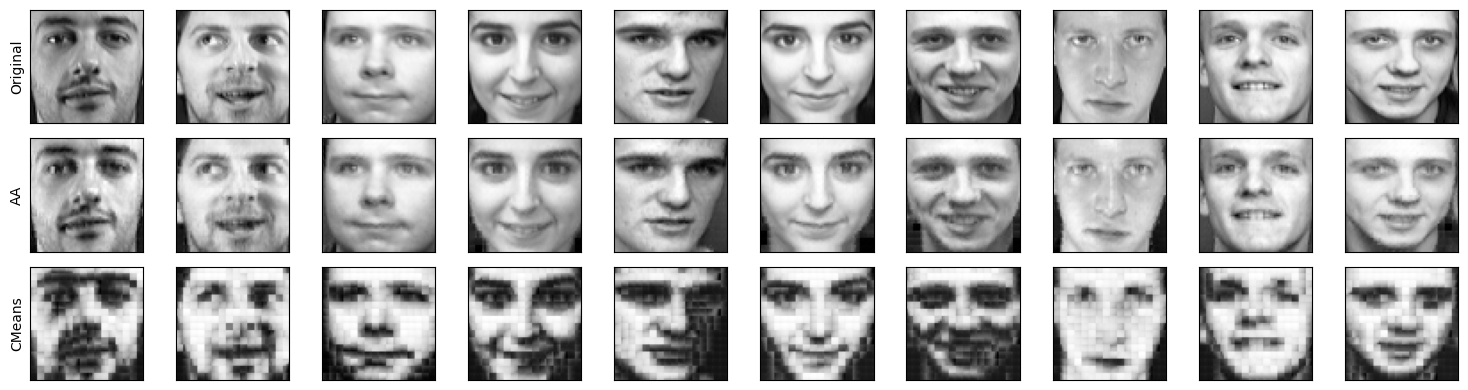

In [548]:
fig, ax = plt.subplots(3, 10, figsize=(15, 4))

idx = np.random.choice(n_samples, 10)

for i in range(10):
    ax[0, i].imshow(data[idx[i]], cmap='gray')
    ax[1, i].imshow(compressed_aa[idx[i]], cmap='gray')
    ax[2, i].imshow(compressed_cmeans[idx[i]], cmap='gray')

    # Only keep ylabel
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    ax[2, i].set_xticks([])
    ax[2, i].set_yticks([])



# Add lateral legends
ax[0, 0].set_ylabel('Original')
ax[1, 0].set_ylabel('AA')
ax[2, 0].set_ylabel('CMeans')

plt.tight_layout()

# save the figure
plt.savefig('compression_faces.pdf')
plt.show()
